In [9]:
# импортируем необходимые библиотеки, классы и функции
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from statsmodels.tsa.ar_model import AutoReg

from statsmodels.tsa.api import VAR
import cp

In [19]:
pip install cp

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for cp: filename=cp-2020.12.3-py3-none-any.whl size=1422 sha256=c249f408a259fbac3fbce0cc67cfb77815ef9e33ca7b4e9c19d4e52c438411c3
  Stored in directory: c:\users\msi-1\appdata\local\pip\cache\wheels\a8\c5\92\4956183a677aa95219dc268a30c392005da3934bdb0cd3f937
Successfully built cp
Note: you may need to restart the kernel to use updated packages.


In [10]:
# отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [11]:
# настроим удобное отображение графиков и таблиц
%matplotlib inline
plt.rc('figure', figsize=(18, 5))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

In [12]:
# загрузим данные
s = pd.read_csv(
    'div1.csv', 
    index_col=1, 
    parse_dates=True, 
    squeeze=True)

# s.drop(columns=['Ticker'], inplace=True)
s

,Ticker,Div,Month,MC,buyday
Date/Time,,,,,
2013-04-30,ABRD,0,4,3,43
2014-06-27,ABRD,0,6,3,54
2016-11-17,ABRD,0,11,3,59
2017-06-29,ABRD,0,6,3,59
2018-06-25,ABRD,2,6,3,12
...,...,...,...,...,...
2016-07-01,MOEX:UPRO,7,7,0,21
2016-12-16,MOEX:UPRO,2,12,5,38
2017-07-03,MOEX:UPRO,4,7,5,24


In [39]:
class WindowSlider(object):
    
    def __init__(self, window_size = 5):        
        '''
        Window Slider object
        ====================
        w: window_size - number of time steps to look back
        o: offset between last reading and temperature
        r: response_size - number of time steps to predict
        l: maximum length to slide - (#observation - w)
        p: final predictors - (#predictors * w)
        '''
        self.w = window_size
        self.o = 0
        self.r = 1       
        self.l = 0
        self.p = 0
        self.names = []
        
    def re_init(self, arr):
        '''
        Helper function to initializate to 0 a vector
        '''
        arr = np.cumsum(arr)
        return arr - arr[0]
                

    def collect_windows(self, X, window_size=5, offset=0, previous_y=False):
        '''
        Input: X is the input matrix, each column is a variable
        Returns: diferent mappings window-output
        '''
        cols = len(list(X)) - 1
        N = len(X)
        
        self.o = offset
        self.w = window_size
        self.l = N - (self.w + self.r) + 1
        if not previous_y: self.p = cols * (self.w)
        if previous_y: self.p = (cols + 1) * (self.w)
        
        # Create the names of the variables in the window
        # Check first if we need to create that for the response itself
        if previous_y: x = [0, 1]
        if not previous_y: x = X.drop(X.columns[-1], axis=1)  
        print(x)
        for j, col in enumerate(list(x)):        
                
            for i in range(self.w):
                
                name = col + ('(%d)' % (i+1))
                self.names.append(name)
        
        # Incorporate the timestamps where we want to predict
        for k in range(self.r):
            
            name = '∆t' + ('(%d)' % (self.w + k + 1))
            self.names.append(name)
            
        self.names.append('Y')
                
        df = pd.DataFrame(np.zeros(shape=(self.l, (self.p + self.r + 1))), 
                          columns=self.names)
        
        # Populate by rows in the new dataframe
        for i in range(self.l):
            
            slices = np.array([])
            
            # Flatten the lags of predictors
            for p in range(x.shape[1]):
            
                line = X.values[i:self.w + i, p]
                # Reinitialization at every window for ∆T
                if p == 0: line = self.re_init(line)
                    
                # Concatenate the lines in one slice    
                slices = np.concatenate((slices, line)) 
 
            # Incorporate the timestamps where we want to predict
            line = np.array([self.re_init(X.values[i:i+self.w+self.r, 0])[-1]])
            y = np.array(X.values[self.w + i + self.r - 1, -1]).reshape(1,)
            slices = np.concatenate((slices, line, y))
            
            # Incorporate the slice to the cake (df)
            df.iloc[i,:] = slices
            
        return df

,Date/Time,Close
Ticker,,
BTC-USD,4/1/2014,479.56
BTC-USD,4/2/2014,437.08
BTC-USD,4/3/2014,445.60
BTC-USD,4/4/2014,449.81
BTC-USD,4/5/2014,461.70
...,...,...
BTC-USD,1/5/2023,16834.96
BTC-USD,1/6/2023,16955.97
BTC-USD,1/7/2023,16971.02


In [40]:
trainset = s.iloc[:-100,:]
testset = s.iloc[-100:,:]
w = 5
train_constructor = WindowSlider()
train_windows = train_constructor.collect_windows(trainset.iloc[:,1:], 
                                                  previous_y=False, window_size=5)

test_constructor = WindowSlider()
test_windows = test_constructor.collect_windows(testset.iloc[:,1:],
                                                previous_y=False, window_size=5)

# train_constructor_y_inc = WindowSlider()
# train_windows_y_inc = train_constructor_y_inc.collect_windows(trainset.iloc[:,1:], 
#                                                   previous_y=True)

# test_constructor_y_inc = WindowSlider()
# test_windows_y_inc = test_constructor_y_inc.collect_windows(testset.iloc[:,1:],
#                                                 previous_y=True)

train_windows

Empty DataFrame
Columns: []
Index: [BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, BTC-USD, ...]

[3106 rows x 0 columns]
Empty DataFrame
Columns: []
Index:

,∆t(6),Y
0,2255.20,461.02
1,2271.03,452.90
2,2278.33,452.90
3,2277.82,449.30
4,2182.89,366.77
...,...,...
3096,95332.05,19090.84
3097,95446.75,19410.45
3098,96124.39,19603.59
3099,96749.53,19426.99


In [2]:
from sklearn.model_selection import train_test_split
X = s.iloc[:,:-1]
y = s.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=241)

NameError: name 's' is not defined

In [1]:
from sklearn.linear_model import LinearRegression
import time
t0 = time.time()
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


lr_y = y_test.values

lr_y_pred = lr_model.predict(X_test)
tF = time.time()

lr_residuals = lr_y_pred - lr_y
lr_rmse = mean_squared_error(lr_y_pred, lr_y)
print('RMSE = %.2f' % lr_rmse)
print('Time to train = %.2f seconds' % (tF - t0))## RMSE = 3.84
## Time to train = 0.00 seconds

NameError: name 'X_train' is not defined

In [166]:
from sklearn.model_selection import GridSearchCV
parametrs = { 'epsilon': np.arange(1.35,5,0.25),
            'max_iter' : [50,100,200,300,400],
            }
grid = GridSearchCV(lr_model, parametrs, cv=3, scoring = 'neg_mean_squared_error')
grid.fit(trainset.iloc[:,:-1], trainset.iloc[:,-1])
print(f'Лучшие параметры :\n {grid.best_params_}')
print(f'Значение rmse: {grid.best_score_}')

Лучшие параметры :
 {'epsilon': 3.1, 'max_iter': 300}
Значение rmse: -479127.7453922201


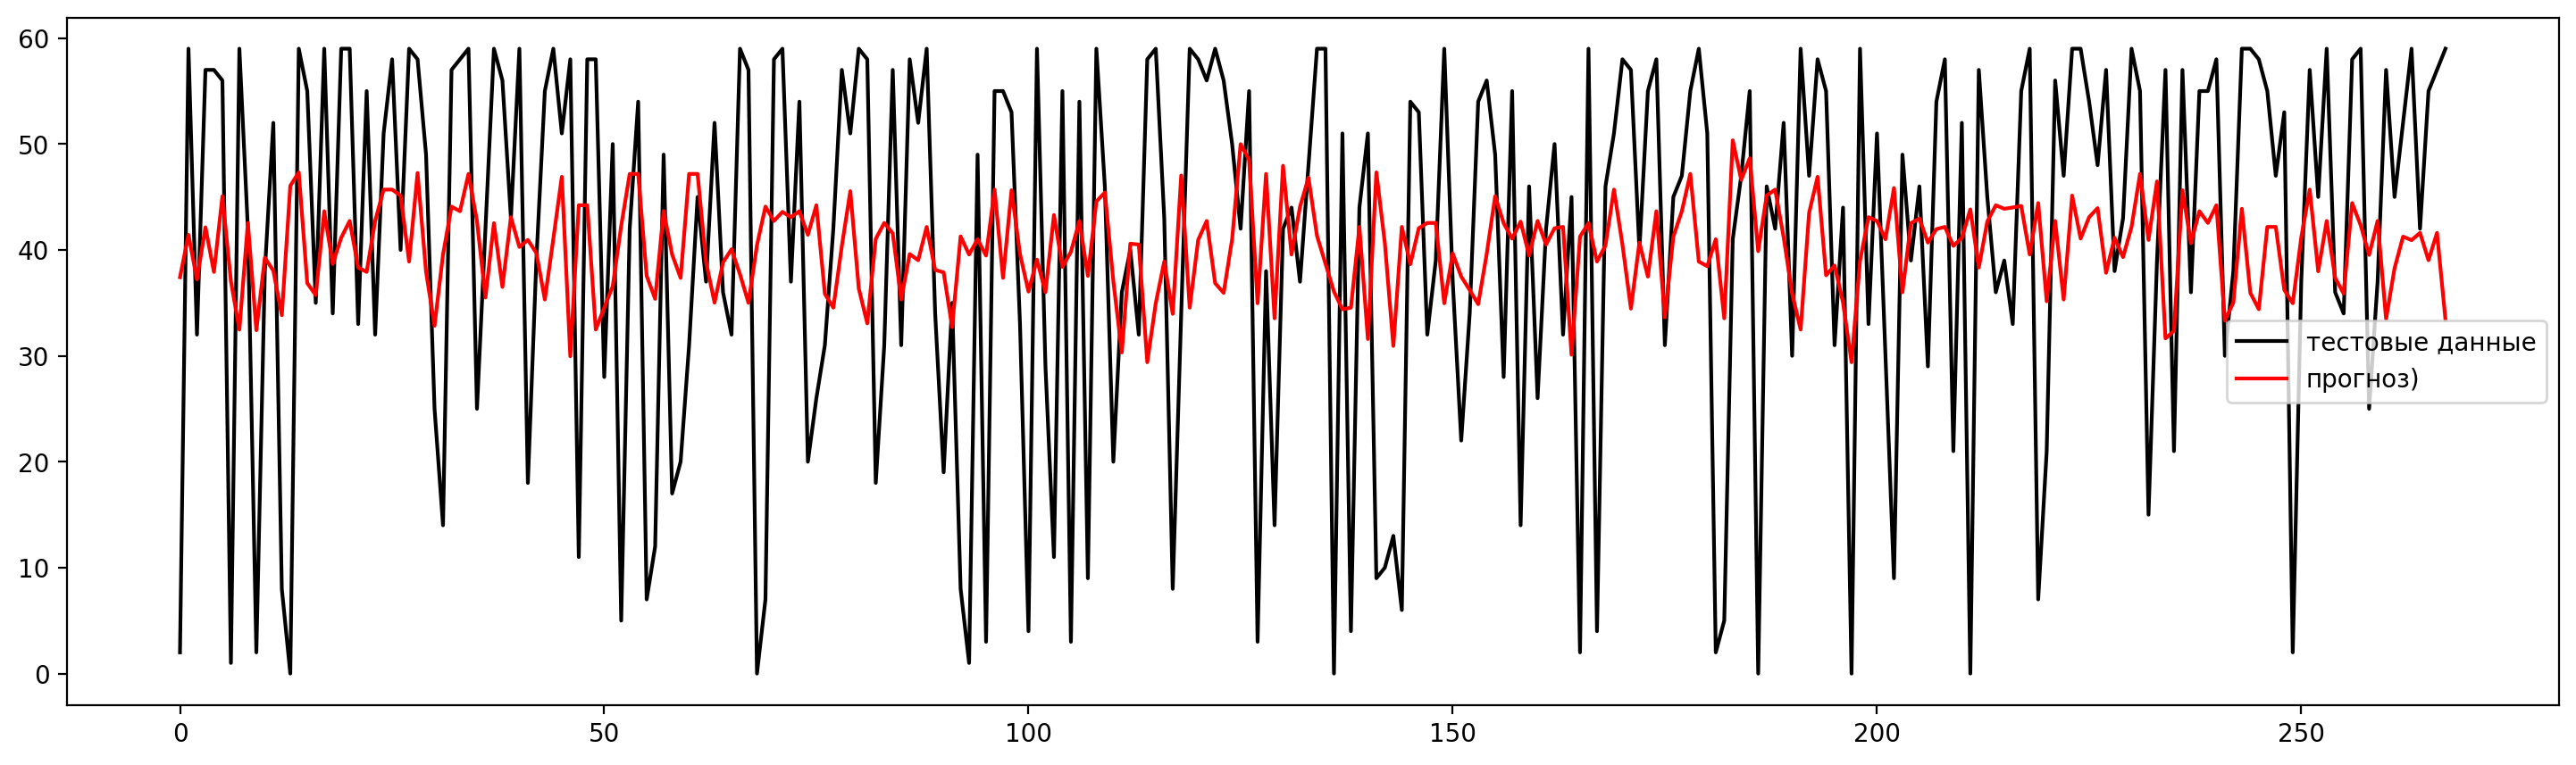

In [228]:
plt.plot(lr_y, label='тестовые данные', color = 'black')
plt.plot(lr_y_pred, color='red', label=f'прогноз)')
plt.legend();

In [64]:
lr_model.coef_

array([-0.01357547,  0.06396827, -0.1232938 ,  0.05087431,  0.05633201,
        0.17574714, -0.16102525, -0.10933714, -0.10213692,  0.12222343,
       -0.02869318, -0.04499086,  0.3600303 ,  0.1847785 , -0.06912795,
       -0.07540773,  0.69648286,  0.33614874, -0.00088962, -0.03880283])

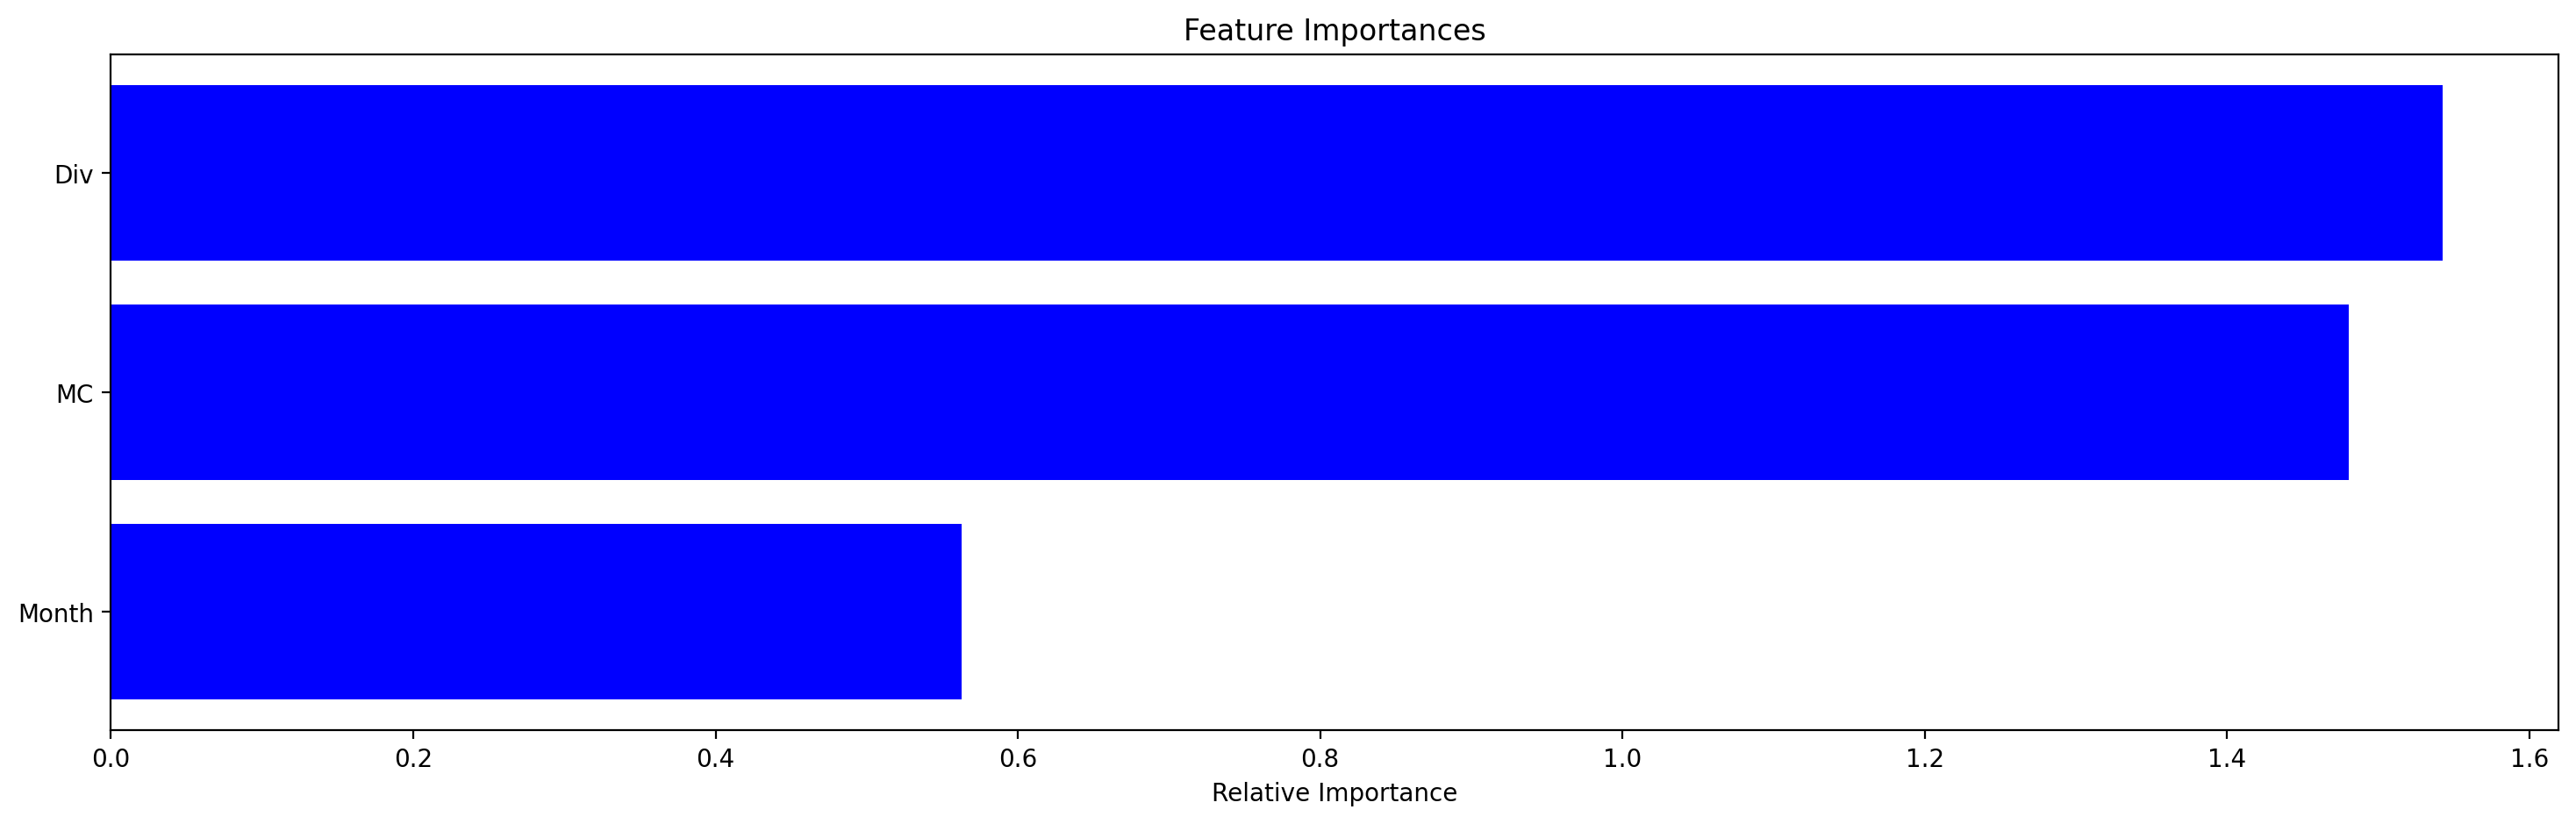

In [229]:
features = trainset.columns
importances = abs(lr_model.coef_)
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [59]:
# разобьем данные на обучающую и тестовую выборки так,
# чтобы в тесте оказалось 7 наблюдений
X = s.price.values
train, test = X[0:len(X)-7], X[len(X)-7:]

In [60]:
# зададим периоды скользящей средней
periods = [3, 10, 15, 20]

In [66]:
# построение моделей MA и их графиков выполним в цикле
colors = {3: "red", 10: "blue", 15: "green", 20: "purple"}
for i in periods:
    # обучим MA(i)-модель
    model = VAR(train)
    model_fit = model.fit()
    
    # выведем сводку по модели
#     print(f'Сводка по модели МА({i})')
#     display(model_fit.summary())
    
    # делаем прогнозы на 7 временных шагов вперед
    # для этого в методе .predict() задаем начало и конец 
    # периода прогнозирования
    predictions = model_fit.predict(
        start=len(train), end=len(train)+len(test)-1)
    
    # напечатаем прогнозы на 7 временных шагов вперед
#     print(f'Для MA({i})')
#     for j in range(len(predictions)):
#         print('спрогнозированное=%f, фактическое=%f' % (predictions[j], test[j]))
    # вычислим значение метрики RMSE
    rmse = np.sqrt(
        mean_squared_error(test, predictions))
    print(f'\nRMSE lags({i}) на тестовой выборке: %.3f' % rmse)
    
    # визуализируем прогнозы
    color = colors[i]
    if i == 3:
        plt.plot(test, label='тестовые данные', color = 'black')
    plt.plot(predictions, color=color, label=f'прогнозы MA({i})')
    plt.legend();

ValueError: Only gave one variable to VAR

In [20]:
test

array([17109.     , 17204.81055, 17772.5    , 17801.66992, 17354.24023,
       16650.82031, 16790.66016, 16755.7793 , 16442.38086, 16912.30078,
       16825.81055, 16857.50977, 16790.58008, 16854.94922, 16852.76953,
       16949.33008, 16702.71094, 16545.25   , 16638.01953, 16607.59961,
       16549.     , 16637.23047, 16667.75   , 16664.16992, 16851.78906,
       16834.96094, 16955.9707 , 16971.01953, 17121.93945, 17193.23047])

С ростом периода MA точность прогноза повышается до некоторого значения. При периоде равном 100 точность прогноза становится ниже особенно с ростом числа последующих прогнозов, это объясняю недостаточным количество значений исторической выборки для значения 100, т.к. кол-во значений в нашей выборки всего 637